In [1]:
from datetime import datetime
import os
import io
import re
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, average_precision_score,\
  classification_report, confusion_matrix, plot_precision_recall_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn import preprocessing
import xgboost as xgb

In [2]:
def get_df (file_name, print_df=False):
    path = os.path.join(os.getcwd(), 'data', file_name)
    df = pd.read_csv(path, encoding='latin-1')
    if print_df is True:
        display(df.head())
        print(df.shape)
    return df

In [5]:
df_driver = get_df('drivers.csv', print_df=True)

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


(848, 9)


In [6]:
df_driver.loc[df_driver['driverId']==30]

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
29,30,michael_schumacher,\N,MSC,Michael,Schumacher,1969-01-03,German,http://en.wikipedia.org/wiki/Michael_Schumacher


In [7]:
df_race = get_df('races.csv', print_df=True)

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


(1033, 8)


In [8]:
df_result = get_df('results.csv', print_df=True)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


(24620, 18)


In [9]:
df_constr = get_df('constructors.csv', print_df=True)

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


(210, 5)


In [10]:
df_constr_result = get_df('constructor_results.csv', print_df=True)

,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N


(11560, 5)


In [11]:
df_constr_stand = get_df('constructor_standings.csv', print_df=True)

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


(12326, 7)


### Add win column

In [12]:
df = get_df('results.csv')
df['win'] = 0
df['win'] = df['position'].mask(df_result['position'] != '1', 0)
display(df.head())
print(df.shape)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,win
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,0
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,0
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,0
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,0


(24620, 19)


### Top drivers in history

In [13]:
n_wins = df_result.loc[df['position'] == str(1)]
n_wins_driver = n_wins.groupby('driverId')['driverId'].count()
n_wins_driver.head()

driverId
1    84
3    23
4    32
5     1
8    21
Name: driverId, dtype: int64

In [14]:
n_wins_top_10 = n_wins_driver.nlargest(10)
n_wins_top_10.head()

driverId
30     91
1      84
20     53
117    51
102    41
Name: driverId, dtype: int64

In [15]:
names = []
for Id in n_wins_top_10.index:
    names.append(df_driver.loc[df_driver['driverId'] == Id, 'surname'].values[0])
print(names)

['Schumacher', 'Hamilton', 'Vettel', 'Prost', 'Senna', 'Alonso', 'Mansell', 'Stewart', 'Lauda', 'Clark']


<BarContainer object of 10 artists>

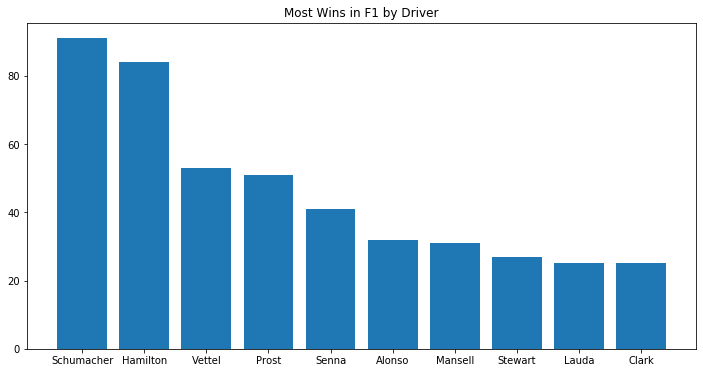

In [16]:
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Most Wins in F1 by Driver')
plt.bar(names, n_wins_top_10)

### Top constructors in history

In [17]:
n_wins_constructor = n_wins.groupby('constructorId')['constructorId'].count()
n_wins_constructor.head()

constructorId
1    178
2      1
3    114
4     35
5      1
Name: constructorId, dtype: int64

In [18]:
n_wins_top_10c = n_wins_constructor.nlargest(10)
n_wins_top_10c.head()

constructorId
6      239
1      178
3      114
131    102
9       62
Name: constructorId, dtype: int64

In [19]:
names_c = []
for Id in n_wins_top_10c.index:
      names_c.append(df_constr.loc[df_constr['constructorId'] == Id, 'name'].values[0])
print(names_c)

['Ferrari', 'McLaren', 'Williams', 'Mercedes', 'Red Bull', 'Team Lotus', 'Renault', 'Benetton', 'Tyrrell', 'Brabham']


<BarContainer object of 10 artists>

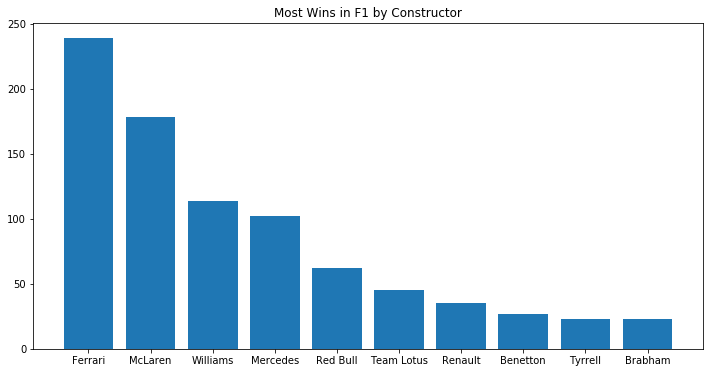

In [20]:
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Most Wins in F1 by Constructor')
plt.bar(names_c, n_wins_top_10c)

### Label: time from first position

In [21]:
df_race = get_df('races.csv')
year=[]
for raceId in df_race['raceId']:
    year.append(df_race.loc[df_race['raceId'] == raceId, 'year'].values[0])

In [22]:
df_race['year'] = year
df_race['year'].unique()

array([2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999,
       1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 2010, 1989,
       1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978,
       1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967,
       1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956,
       1955, 1954, 1953, 1952, 1951, 1950, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

In [23]:
time_from_first = []
current_time = 0

for index, row in df_result.iterrows():
    if row['milliseconds'] == '\\N':
        time_from_first.append(1000000)
    elif int(row['positionOrder']) == 1:
        time_from_first.append(0)
        current_time = int(row['milliseconds'])
    else:
        time_from_first.append(int(row['milliseconds']) - current_time)
  

In [24]:
display(df_result.loc[df_result['raceId']==69]['milliseconds'])

1094    5032413
1095    5048564
1096    5056366
1097    5066514
1098    5076009
1099    5079130
1100    5081282
1101    5108508
1102    5109345
1103         \N
1104         \N
1105         \N
1106         \N
1107         \N
1108         \N
1109         \N
1110         \N
1111         \N
1112         \N
1113         \N
1114         \N
1115         \N
Name: milliseconds, dtype: object

In [25]:
df_result = get_df('results.csv')
mask = (df_result['fastestLapTime'] != 0)
races = df_result['raceId'].unique()

# Create new features
df_result['min_fastest_lap_time'] = 0
df_result['min_fastest_lap_speed'] = 0
df_result['avg_fastest_lap_time'] = 0
df_result['avg_fastest_lap_speed'] = 0
df_result['max_fastest_lap_time'] = 0
df_result['max_fastest_lap_speed'] = 0
missing_time = []
for race in races:
    set_time = df_result.loc[(df_result['raceId']==race) &\
                          (df_result['fastestLapTime']!='\\N')]
    times = set_time['fastestLapTime']
    speeds = set_time['fastestLapSpeed']
    
#     print(times)
    count = times.size
    
    if count is 0:
        missing_time.append(race)
    else:
        avg_time = 0
        avg_speed = 0
        
        # Change time strings to time in seconds
        for i, row in set_time.iterrows():
            timestring = row['fastestLapTime']
            time_list = re.split(':', timestring)
            sec_time = float(time_list[0]) * 60 + float(time_list[1])
            
            df_result.loc[(df_result['fastestLapTime'] == timestring) &
                          (df_result['raceId'] == race), 'fastestLapTime'] = sec_time
            avg_time += sec_time
        
        # Find avg fastest lap time
        avg_time = avg_time / count
        mask = (df_result['raceId']==race)
        df_result.loc[mask, 'avg_fastest_lap_time'] = avg_time
        
        # Find slowest overall lap time
        set_time = df_result.loc[(df_result['raceId']==race) &\
                          (df_result['fastestLapTime']!='\\N')]
        times = set_time['fastestLapTime']
        max_time = times.max()
        df_result.loc[mask, 'max_fastest_lap_time'] = max_time
        
        # Find fastest overall lap time
        min_time = times.min()
        df_result.loc[mask, 'min_fastest_lap_time'] = min_time
        
        all_starters = df_result.loc[df_result['raceId']==race]
        
        # Find avg fastest lap speed
        for speed in speeds:
            avg_speed += float(speed)
        avg_speed = avg_speed / count
        df_result.loc[mask, 'avg_fastest_lap_speed'] = avg_speed
        
        # Find max overall fastest speed
        max_speed = speeds.max()
        df_result.loc[mask, 'max_fastest_lap_speed'] = max_speed
        
        # Find max overall fastest speed
        min_speed = speeds.min()
        df_result.loc[mask, 'min_fastest_lap_speed'] = min_speed

print(len(missing_time), ' races are missing fastest lap data')

713  races are missing fastest lap data


In [26]:
# Remove years 1950-2002 with no timing data
years = []
for race in missing_time:
    no_times = df_race.loc[df_race['raceId']==race]
    year = no_times['year'].unique()[0]
    if year not in years:
        years.append(year)

# filter out races with no timing data
for race in missing_time:
    df_result = df_result.loc[df_result['raceId'] != race]
    
display(df_result.shape)

(6511, 24)

In [27]:
display(df_result)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,rank,fastestLapTime,fastestLapSpeed,statusId,min_fastest_lap_time,min_fastest_lap_speed,avg_fastest_lap_time,avg_fastest_lap_speed,max_fastest_lap_time,max_fastest_lap_speed
0,1,18,1,1,22,1,1,1,1,10.0,...,2,87.452,218.300,1,87.418,207.461,89.100529,214.306647,92.021,218.385
1,2,18,2,2,3,5,2,2,2,8.0,...,3,87.739,217.586,1,87.418,207.461,89.100529,214.306647,92.021,218.385
2,3,18,3,3,7,7,3,3,3,6.0,...,5,88.09,216.719,1,87.418,207.461,89.100529,214.306647,92.021,218.385
3,4,18,4,4,5,11,4,4,4,5.0,...,7,88.603,215.464,1,87.418,207.461,89.100529,214.306647,92.021,218.385
4,5,18,5,1,23,3,5,5,5,4.0,...,1,87.418,218.385,1,87.418,207.461,89.100529,214.306647,92.021,218.385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24615,24621,1030,841,51,99,16,16,16,16,0.0,...,15,103.256,193.639,11,99.283,191.333,102.185950,195.705200,104.500,201.387
24616,24622,1030,847,3,63,18,17,17,17,0.0,...,13,103.074,193.981,11,99.283,191.333,102.185950,195.705200,104.500,201.387
24617,24623,1030,842,5,10,11,18,18,18,0.0,...,10,102.414,195.231,12,99.283,191.333,102.185950,195.705200,104.500,201.387
24618,24624,1030,9,3,88,19,19,19,19,0.0,...,20,104.5,191.333,12,99.283,191.333,102.185950,195.705200,104.500,201.387


In [28]:
df_result['fastest_time_delta'] = 0
df_result['fastest_speed_delta'] = 0
df_result['avg_time_delta'] = 0
df_result['avg_speed_delta'] = 0
df_result['gained_pos'] = 0

# remove dns/first lap crashes for now since this may bias data
# TODO: consider adding dns/first lap crashes back in (use null_mask)
# null_mask = (df_result['fastestLapTime']=='\\N')
mask = (df_result['fastestLapTime']!='\\N')
df_thin = df_result.loc[mask]

# Coerce columns to float
df_thin['fastestLapTime'] = df_thin['fastestLapTime'].astype(float)
df_thin['fastestLapSpeed'] = df_thin['fastestLapSpeed'].astype(float)
df_thin['min_fastest_lap_speed'] = df_thin['min_fastest_lap_speed'].astype(float)
df_thin['max_fastest_lap_speed'] = df_thin['max_fastest_lap_speed'].astype(float)

# Deltas are in percentages above fastest lap time
df_thin['fastest_time_delta'] = df_thin['fastestLapTime'] / df_thin['min_fastest_lap_time']

# Deltas are in percentages above fastest lap speed
df_thin['fastest_speed_delta'] = df_thin['fastestLapSpeed'] / df_thin['max_fastest_lap_speed']

# Deltas are in percentages w.r.t avg fastest lap time
df_thin['avg_time_delta'] = df_thin['fastestLapTime'] / df_thin['avg_fastest_lap_time']

# Deltas are in percentages above avg fastest lap speed
df_thin['avg_speed_delta'] = df_thin['fastestLapSpeed'] / df_thin['avg_fastest_lap_speed']

# Positions gained
# df_thin['gained_pos'] = df_thin['positionOrder'] - df_thin['grid']
for index, row in df_thin.iterrows():
    if row['grid'] == 0:
        df_thin.at[index, 'gained_pos'] = row['positionOrder'] - 20
    else:
        df_thin.at[index, 'gained_pos'] = row['positionOrder'] - row['grid']

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [29]:
years = list(range(2004, 2020))

# create dict to associate raceid with year/round
year_dict = {}
df_race = get_df('races.csv')
for year in years:
    df_year = df_race.loc[df_race['year']==year]
    
    round_dict = {}
    rounds = df_year['round'].unique()
    for rnd in rounds:
        raceId = df_race.loc[(df_race['year']==year) & (df_race['round']==rnd)]['raceId'].unique()
        round_dict[rnd] = raceId[0]
    year_dict[year] = round_dict
    

In [30]:
# Add win column
df_thin['win'] = 0
df_thin['win'] = df_thin['position'].mask(df_thin['position'] != '1', 0)
df_thin['win'] = df_thin['win'].astype(int)

# Create df of previous race results
df_prev = None
for year in year_dict.keys():
    for rnd in year_dict[year].keys():
        
        if rnd > 1:
            # drop first rounds, get previous round raceId
            prevId = year_dict[year][rnd-1]
            race_data = df_thin.loc[df_thin['raceId']==prevId]
            
            # set current race id
            raceId = year_dict[year][rnd]
            race_data['current_id'] = raceId
            
            # Get fastest lap time and fastest speed of winner
            winner = race_data.loc[race_data['win']==1]
            winner_laptime = winner['fastestLapTime'].unique()[0]
            winner_speed = winner['fastestLapSpeed'].unique()[0]

            # Calculate deltas with respect to race winner
            race_data['winner_fastest_lap_delta'] = race_data['fastestLapTime'] - winner_laptime
            race_data['winner_fastest_speed_delta'] = race_data['fastestLapSpeed'] - winner_speed
            
            # Add true result column, current quali grid position (prior to race)
            race_data['actual_result'] = 0
            cur = df_result.loc[df_result['raceId']==raceId]
            
            for driver in race_data['driverId'].unique():
                try:
                    cur_data = cur.loc[cur['driverId']==driver]['positionOrder'].unique()[0]
                    past_entry_id = race_data.loc[race_data['driverId']==driver]['resultId'].unique()[0]
                    race_data.at[past_entry_id, 'actual_result'] = cur_data
                except:
                    # account for dnf/dsq
                    past_entry_id = race_data.loc[race_data['driverId']==driver]['resultId'].unique()[0]
                    race_data.at[past_entry_id, 'actual_result'] = 20
            race_data = race_data.dropna()
#             sns.distplot(x);
            # default to 20 to account for engine penalties, etc.
            race_data['cur_grid'] = 20
            for driver in race_data['driverId'].unique():
                try:
                    cur_data = cur.loc[cur['driverId']==driver]['grid'].unique()[0]
                    past_entry_id = race_data.loc[race_data['driverId']==driver]['resultId'].unique()[0]
                    race_data.at[past_entry_id, 'cur_grid'] = cur_data
                except:
                    # account for dnf/dsq
                    past_entry_id = race_data.loc[race_data['driverId']==driver]['resultId'].unique()[0]
                    race_data.at[past_entry_id, 'cur_grid'] = 20
            race_data = race_data.dropna()
            
            # add finishing time delta to winner
            times = race_data.loc[race_data['milliseconds']!='\\N']['milliseconds']
            time_num = []
            for time in times:
                time_num.append(float(time))
            max_time = max(time_num)
            min_time = min(time_num)
            race_data['winner_delta'] = 2 * int(max_time)
            for index, row in race_data.iterrows():
                if row['milliseconds'] == '\\N':
                    race_data.at[index, 'winner_delta'] = 2 * int(max_time)
                elif int(row['positionOrder']) == 1:
                    race_data.at[index, 'winner_delta'] = 0
                else:
                    race_data.at[index, 'winner_delta'] = int(row['milliseconds']) - int(min_time)
                    
            if df_prev is None:
                # Initial df assignment
                df_prev = race_data
            else:
                # concatenate additional dfs
                df_prev = pd.concat([df_prev, race_data])
# df_prev = df_prev.dropna()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [32]:
# fix zero valued actual results
mask = df_prev['actual_result'] == 0
zero_df = df_prev.loc[mask]
count = 0
for i, row in zero_df.iterrows():
    
    actual_result = df_result.loc[(df_result['raceId']==row['current_id']) &
                                 (df_result['driverId']==row['driverId'])]
    try:
        result_pos = actual_result['positionOrder'].unique()[0]
        df_prev.at[i, 'actual_result'] = result_pos
    except:
        ++count
print(count)

# display(df_prev.loc[df_prev['actual_result']==0])
        
# drop stubborn row
df_prev = df_prev.drop(22823)

# display(df_prev.loc[df_prev['actual_result']==0])

0


In [74]:
# add on features from Vijay's dataset
ft_2 = pd.read_csv('features.csv')
display(ft_2)

df_full = df_prev

# list of desired features
field_list = ['previous_finishes', 'previous_wins', 
              'previous_finishes_c', 'previous_wins_c']
for field in field_list:
    df_full[field] = 0.0
    

for i, row in df_full.iterrows():
    for field in field_list:
        cur_id = row['current_id']
        val = -1
        
        # Convert all nan to numpy nan's
        try:
            val = ft_2.loc[(ft_2['resultId']) == cur_id][field].unique()[0]
        except:
            val = np.nan
            
        if val == 'nan' or val == 'NaN':
            val = np.nan
            
        try:
            df_full.at[i, field] = val
        except:
            print(val)
display(df_full)

,Unnamed: 0,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,...,win,year,Time_From_First,circuitId,average_lap,finished,previous_finishes,previous_wins,previous_finishes_c,previous_wins_c
0,0,1,18,1,1,22,1,1,1,1,...,1,2008,0,1,88747.672414,1,1.000000,0,0.625,0
1,1,2,18,2,2,3,5,2,2,2,...,0,2008,5478,1,98351.338616,1,0.375000,0,0.750,0
2,2,3,18,3,3,7,7,3,3,3,...,0,2008,8163,1,90039.245614,1,0.000000,0,0.375,0
3,3,4,18,4,4,5,11,4,4,4,...,0,2008,17181,1,94878.762558,1,0.833333,1,0.750,2
4,4,5,18,5,1,23,3,5,5,5,...,0,2008,18014,1,90598.421053,1,0.000000,0,0.625,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24615,24615,24621,1030,841,51,99,16,16,16,16,...,0,2019,1000000,24,NaN,0,NaN,0,NaN,0
24616,24616,24622,1030,847,3,63,18,17,17,17,...,0,2019,1000000,24,NaN,0,NaN,0,0.250,0
24617,24617,24623,1030,842,5,10,11,18,18,18,...,0,2019,1000000,24,109282.633655,0,0.000000,0,0.125,0
24618,24618,24624,1030,9,3,88,19,19,19,19,...,0,2019,1000000,24,106431.427273,0,1.000000,0,0.250,0


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,current_id,winner_fastest_lap_delta,winner_fastest_speed_delta,actual_result,cur_grid,winner_delta,previous_finishes,previous_wins,previous_finishes_c,previous_wins_c
1514,1515.0,90.0,30.0,6.0,1,1.0,1,1,1.0,10.0,...,91.0,0.000,0.000,1.0,20.0,0,0.666667,1.0,0.666667,2.0
1515,1516.0,90.0,22.0,6.0,2,2.0,2,2,2.0,8.0,...,91.0,0.054,-0.145,1.0,1.0,13605,0.666667,1.0,0.666667,2.0
1516,1517.0,90.0,4.0,4.0,8,5.0,3,3,3.0,6.0,...,91.0,0.963,-2.568,4.0,3.0,34673,0.666667,1.0,0.666667,2.0
1517,1518.0,90.0,23.0,3.0,4,8.0,4,4,4.0,5.0,...,91.0,1.699,-4.492,7.0,19.0,60423,0.666667,1.0,0.666667,2.0
1518,1519.0,90.0,31.0,3.0,3,3.0,5,5,5.0,4.0,...,91.0,1.161,-3.089,19.0,7.0,68536,0.666667,1.0,0.666667,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24595,24601.0,1029.0,9.0,3.0,88,19.0,16,16,16.0,0.0,...,1030.0,3.691,-10.837,9.0,13.0,11225474,1.000000,0.0,1.000000,0.0
24596,24602.0,1029.0,20.0,6.0,5,2.0,17,17,17.0,0.0,...,1030.0,0.522,-1.600,14.0,14.0,11225474,1.000000,0.0,1.000000,0.0
24597,24603.0,1029.0,844.0,6.0,16,14.0,18,18,18.0,0.0,...,1030.0,0.561,-1.719,17.0,18.0,11225474,1.000000,0.0,1.000000,0.0
24598,24604.0,1029.0,840.0,211.0,18,17.0,19,19,19.0,0.0,...,1030.0,1.741,-5.249,15.0,15.0,11225474,1.000000,0.0,1.000000,0.0


In [34]:
# display(df_prev.dtypes)
cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'win', 'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId']
cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'win', 'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
        'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]
data_full = df_prev[cols_full]

data.to_csv('feature_data.csv', index=False)
data_full.to_csv('feature_full.csv', index=False)

In [84]:
def downsample(df_full, classes, class_lambda):
    # Apply lambda to change target to class id
    df_full['actual_result'] = df_full['actual_result'].apply(class_lambda)
    
    # Separate majority and minority classes
    class_size = []
    class_df_dict = {}
    for cla in classes:
        class_df = df_full[df_full.actual_result==cla]
        class_df_dict[cla] = class_df
        class_size.append(class_df.shape[0])

    # find min class size and corresponding df
    min_size = min(class_size)

    # Identify minority class
    min_class = -1
    for i in range(0, len(class_size)):
        if class_size[i] is min_size:
            min_class = i;
            break;
    
    # Resample non-minority classes
    downsample_dict = {}
    for key in class_df_dict.keys():
        if key is not min_class:
            downsample_dict[key] = resample(class_df_dict[key], 
                                     replace=False,    # sample without replacement
                                     n_samples=min_size,     # to match minority class
                                     random_state=42) # reproducible results
    
    # Create downsampled dataframe
    df_downsampled = class_df_dict[min_class]
    for key in downsample_dict.keys():
        df_downsampled = pd.concat([df_downsampled, downsample_dict[key]])

        df_downsampled.actual_result.value_counts()
        
    return df_downsampled



def ordered_features(feature_importances, features):
    ordered = []
    importances = []
    
    while(len(ordered) < len(features)):
        max_fea = 0
        max_pos = 0
        for i in range(len(features)):
            if feature_importances[i] > max_fea and features[i] not in ordered:
                max_fea = feature_importances[i]
                max_pos = i
        ordered.append(features[max_pos])
        importances.append(max_fea)
    
    ordered.reverse()
    importances.reverse()

    fig = plt.figure()
    f, ax = plt.subplots(figsize=(10,10))
    ax.barh(ordered, importances)
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importances')
    plt.show()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGE

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       300
           1       0.77      0.74      0.76       301

    accuracy                           0.76       601
   macro avg       0.76      0.76      0.76       601
weighted avg       0.76      0.76      0.76       601



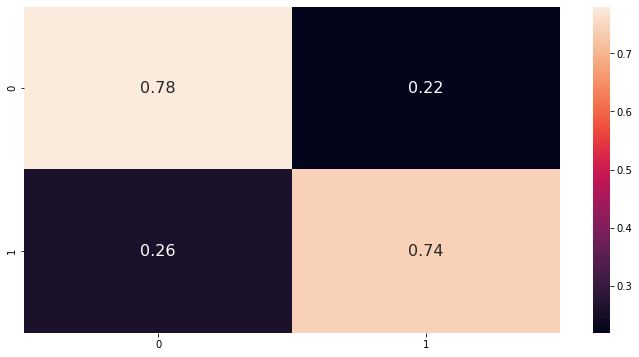

In [36]:
# Podium classifier using 5-Fold Logistic Regression
cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId']
# cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
#         'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]

classes = [0,1]
class_lambda = lambda x: 0 if x < 4 else 1
df_downsampled = downsample(data, classes, class_lambda)
    
# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId']
features = df_downsampled.drop(drop_col, axis=1)

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train log reg classifier
model = LogisticRegressionCV(cv=5, random_state=0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Create confusion matrix heatmap
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Report scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       109
           1       0.76      0.68      0.72       108

    accuracy                           0.73       217
   macro avg       0.74      0.73      0.73       217
weighted avg       0.74      0.73      0.73       217



/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


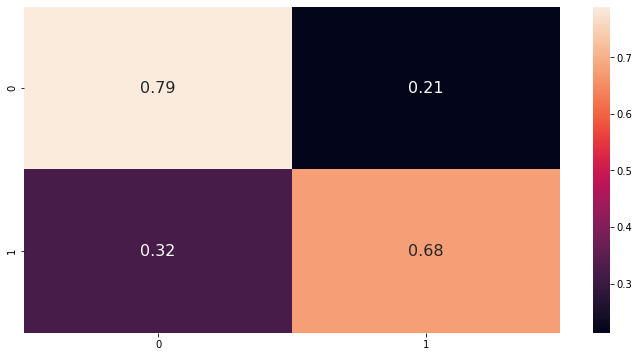

In [44]:
# Win classifier using tree-based XGBClassifier

cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId']
# cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
#         'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]
# display(data)

classes = [0,1]
class_lambda = lambda x: 0 if x < 2 else 1
df_downsampled = downsample(data, classes, class_lambda)
    
# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId']
features = df_downsampled.drop(drop_col, axis=1)

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

# Create confusion matrix heatmap
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Report scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.74      0.78      0.76       300
           1       0.76      0.72      0.74       301

    accuracy                           0.75       601
   macro avg       0.75      0.75      0.75       601
weighted avg       0.75      0.75      0.75       601



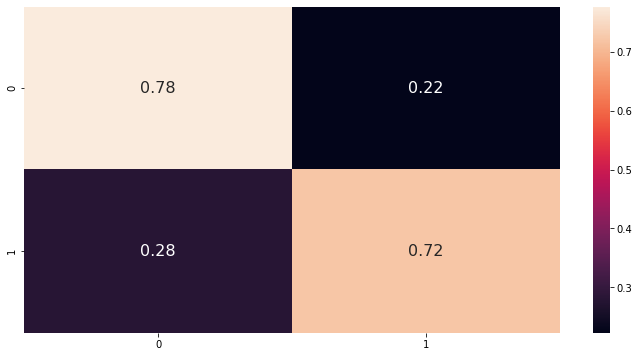

In [37]:
# Podium classifier using tree-based XGBClassifier

cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId']
# cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
#         'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]
data_full = df_prev[cols_full]
# display(data)

classes = [0,1]
class_lambda = lambda x: 0 if x < 4 else 1
df_downsampled = downsample(data, classes, class_lambda)
    
# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId']
features = df_downsampled.drop(drop_col, axis=1)

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

# Create confusion matrix heatmap
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Report scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.67      0.72      0.69       645
           1       0.72      0.68      0.70       694

    accuracy                           0.70      1339
   macro avg       0.70      0.70      0.70      1339
weighted avg       0.70      0.70      0.70      1339



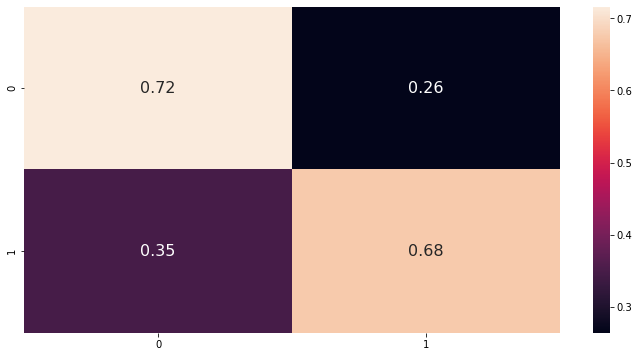

In [38]:
# Points classifier using tree-based XGBClassifier

cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId']
# cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
#         'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]
# display(data)

classes = [0, 1]
class_lambda = lambda x: 0 if x < 11 else 1
df_downsampled = downsample(data, classes, class_lambda)

# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId']
features = df_downsampled.drop(drop_col, axis=1)

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

# Create confusion matrix heatmap
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Report scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.52      0.71      0.60       294
           1       0.31      0.21      0.25       270
           2       0.41      0.49      0.45       305
           3       0.44      0.32      0.37       293

    accuracy                           0.44      1162
   macro avg       0.42      0.43      0.42      1162
weighted avg       0.42      0.44      0.42      1162



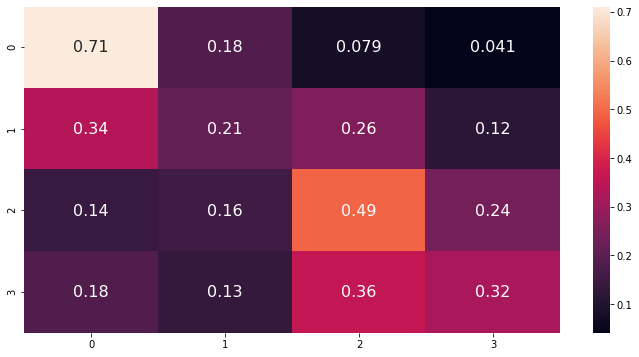

In [39]:
# Position classifier using tree-based XGBClassifier

cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId']
# cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
#         'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]
# display(data)

classes = [0, 1, 2, 3]
class_lambda = lambda x: 0 if x < 4 else (1 if x < 10 else(2 if x < 15 else 3))
df_downsampled = downsample(data, classes, class_lambda)

# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId']
features = df_downsampled.drop(drop_col, axis=1)

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

# Create confusion matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Print scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGE

              precision    recall  f1-score   support

           0       0.53      0.69      0.60       294
           1       0.30      0.26      0.28       270
           2       0.42      0.43      0.42       305
           3       0.40      0.32      0.36       293

    accuracy                           0.43      1162
   macro avg       0.41      0.42      0.41      1162
weighted avg       0.41      0.43      0.42      1162



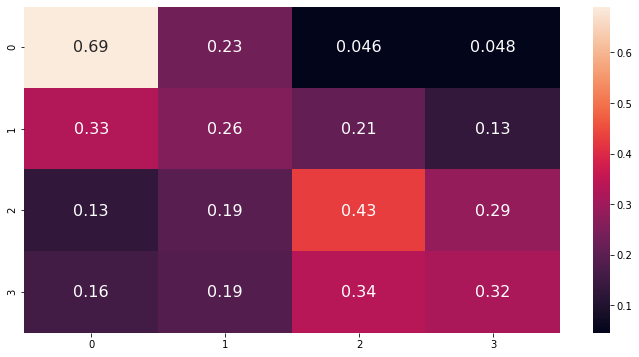

In [45]:
# Position classifier using 5-Fold Logistic Regression

cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId']
# cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
#         'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]
# display(data)

classes = [0, 1, 2, 3]
class_lambda = lambda x: 0 if x < 4 else (1 if x < 10 else(2 if x < 15 else 3))
df_downsampled = downsample(data, classes, class_lambda)

# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId']
features = df_downsampled.drop(drop_col, axis=1)

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train log reg classifier
model = LogisticRegressionCV(cv=5, random_state=0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Create confusion matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Print scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.53      0.71      0.61       294
           1       0.32      0.24      0.27       270
           2       0.44      0.46      0.45       305
           3       0.44      0.38      0.41       293

    accuracy                           0.45      1162
   macro avg       0.43      0.45      0.43      1162
weighted avg       0.44      0.45      0.44      1162



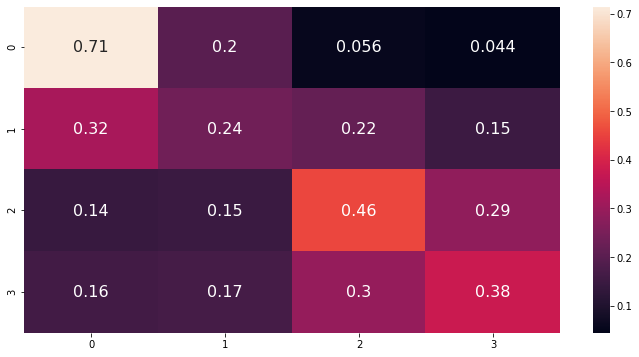

In [55]:
# Position classifier using tree-based XGBClassifier

cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
        'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId', 'driverId']
# cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
#         'previous_wins', 'previous_finishes_c', 'previous_wins_c']

data = df_prev[cols]
# display(data)

classes = [0, 1, 2, 3]
class_lambda = lambda x: 0 if x < 4 else (1 if x < 10 else(2 if x < 15 else 3))
df_downsampled = downsample(data, classes, class_lambda)

# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId']
features = df_downsampled.drop(drop_col, axis=1)
features = pd.get_dummies(features, columns=['constructorId'])
features = pd.get_dummies(features, columns=['driverId'])

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

# Create confusion matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Print scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.55      0.72      0.62       294
           1       0.33      0.22      0.26       270
           2       0.41      0.50      0.45       305
           3       0.44      0.33      0.38       293

    accuracy                           0.45      1162
   macro avg       0.43      0.44      0.43      1162
weighted avg       0.43      0.45      0.43      1162



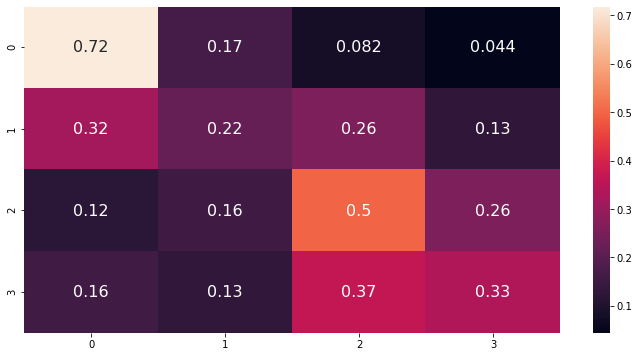

Index(['positionOrder', 'fastest_time_delta', 'fastest_speed_delta',
       'avg_time_delta', 'avg_speed_delta', 'gained_pos',
       'winner_fastest_lap_delta', 'winner_fastest_speed_delta',
       'winner_delta', 'previous_finishes', 'previous_wins',
       'previous_finishes_c', 'previous_wins_c'],
      dtype='object')

[0.4235806  0.05078432 0.04966854 0.05079025 0.05656734 0.0443831
 0.05074107 0.04534335 0.06002546 0.04661203 0.03517127 0.05026269
 0.03607003]
['positionOrder', 'fastest_time_delta', 'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta', 'winner_delta', 'previous_finishes', 'previous_wins', 'previous_finishes_c', 'previous_wins_c']
['previous_wins', 'previous_wins_c', 'gained_pos', 'winner_fastest_speed_delta', 'previous_finishes', 'fastest_speed_delta', 'previous_finishes_c', 'winner_fastest_lap_delta', 'fastest_time_delta', 'avg_time_delta', 'avg_speed_delta', 'winner_delta', 'positionOrder']
[0.035171274, 0.036070026, 0.0443831, 0.045343354, 0.046612028, 0.049668536, 0.050262693, 0.05074107, 0.05078432, 0.050790247, 0.056567337, 0.060025457, 0.4235806]


<Figure size 864x432 with 0 Axes>

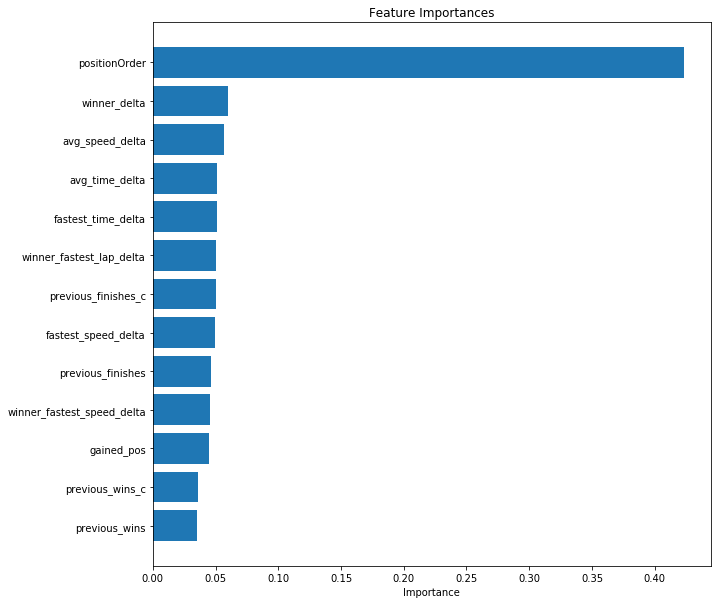

In [86]:
# Position classifier using tree-based XGBClassifier

# cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'driverId']
# cols = ['resultId', 'positionOrder', 'current_id', 'actual_result']
cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos', 'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
        'previous_wins', 'previous_finishes_c', 'previous_wins_c', 'constructorId', 'driverId']

data = df_prev[cols_full]
# display(data)
data.to_csv('feature_data.csv', index=False)

classes = [0, 1, 2, 3]
class_lambda = lambda x: 0 if x < 4 else (1 if x < 10 else(2 if x < 15 else 3))
df_downsampled = downsample(data, classes, class_lambda)

# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId', 'driverId']
# drop_col = ['resultId', 'current_id', 'actual_result']
features = df_downsampled.drop(drop_col, axis=1)
# features = pd.get_dummies(features, columns=['constructorId'])
# features = pd.get_dummies(features, columns=['driverId'])

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

# Create confusion matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Print scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

# Show feature columns
display(features.columns)

# Plot feature importances
col_names = list(features.columns)
ordered_features(model_xgb.feature_importances_, col_names)

In [88]:
# Position classifier using tree-based XGBClassifier

# cols = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
#         'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos',\
#         'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
#         'actual_result', 'constructorId', 'driverId']
# cols = ['resultId', 'positionOrder', 'current_id', 'actual_result']
cols_full = ['resultId', 'positionOrder', 'statusId', 'fastest_time_delta',\
        'fastest_speed_delta', 'avg_time_delta', 'avg_speed_delta', 'gained_pos', 'current_id', 'winner_fastest_lap_delta', 'winner_fastest_speed_delta',\
        'actual_result', 'constructorId', 'winner_delta', 'previous_finishes',
        'previous_wins', 'previous_finishes_c', 'previous_wins_c', 'constructorId', 'driverId']

data = df_prev[cols_full]
# display(data)
data.to_csv('feature_data.csv', index=False)

classes = [0, 1, 2, 3]
class_lambda = lambda x: 0 if x < 4 else (1 if x < 10 else(2 if x < 15 else 3))
df_downsampled = downsample(data, classes, class_lambda)

# create x, y dfs
target = df_downsampled['actual_result']

drop_col = ['resultId', 'current_id', 'actual_result', 'statusId', 'constructorId', 'driverId']
# drop_col = ['resultId', 'current_id', 'actual_result']
features = df_downsampled.drop(drop_col, axis=1)
# features = pd.get_dummies(features, columns=['constructorId'])
# features = pd.get_dummies(features, columns=['driverId'])

# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(features, target,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type, objective='multi:softmax', num_class=4)

/home/edie/miniconda3/envs/env_lab/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [95]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
# skopt_grid = {
#     'max_depth': (4, 12),
#     'learning_rate': (0.01, 0.5), 
#     'n_estimators': (20, 1000), 
#     'gamma': (0, 0.5), 
#     'min_child_weight': (1, 5),
#     'subsample': (0.1, 1),
#     'colsample_bytree': (0.1, 1)}

skopt_grid  = [Integer(3, 20, name='max_depth'),
          Real(0.01,0.1, "log-uniform", name='learning_rate'),
          Integer(1, 5, name='min_child_weight'),
          Integer(20, 1000, name='n_estimators'),
          Real(0,5, name='gamma'),
          Real(0.1, 1.0, name='subsample'),
          Real(0.1, 1.0, name='colsample_bytree'),
          Real(0, 1, name='scale_pos_weight')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(skopt_grid)
def objective(**params):
    model_xgb.set_params(**params)

    return -np.mean(cross_val_score(model_xgb, x_train, y_train, cv=5, n_jobs=-1,
                                    scoring="accuracy"))

In [96]:
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score

res_gp = gp_minimize(objective, skopt_grid, n_calls=100, random_state=0, verbose=True)

"Best score=%.4f" % res_gp.fun

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.8975
Function value obtained: -0.3933
Current minimum: -0.3933
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 21.7582
Function value obtained: -0.3921
Current minimum: -0.3933
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 41.3442
Function value obtained: -0.3881
Current minimum: -0.3933
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 30.3048
Function value obtained: -0.3758
Current minimum: -0.3933
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.3384
Function value obtained: -0.4114
Current minimum: -0.4114
Iteration No: 6 start

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.8612
Function value obtained: -0.4205
Current minimum: -0.4329
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8875
Function value obtained: -0.4289
Current minimum: -0.4329
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 5.7432
Function value obtained: -0.4289
Current minimum: -0.4329
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.9209
Function value obtained: -0.4231
Current minimum: -0.4329
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 68.4188
Function value obtained: -0.3658
Current minimum: -0.4329
Iteration No: 46 s

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.3375
Function value obtained: -0.4309
Current minimum: -0.4329
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 5.2493
Function value obtained: -0.4157
Current minimum: -0.4329
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 31.1247
Function value obtained: -0.4251
Current minimum: -0.4329
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 16.9695
Function value obtained: -0.4177
Current minimum: -0.4329
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.2425
Function value obtained: -0.4283
Current minimum: -0.4329
Iteration No: 86 

'Best score=-0.4340'

In [97]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.100f
- min_child_weight=%d
- n_estimators=%d
- gamma=%.100f
- subsample=%.1000f
- colsample_bytree=%.100f
- scale_pos_weight=%.100f""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4], res_gp.x[5],
                            res_gp.x[6], res_gp.x[7],
                         ))

Best parameters:
- max_depth=3
- learning_rate=0.0100000000000000002081668171172168513294309377670288085937500000000000000000000000000000000000000000
- min_child_weight=5
- n_estimators=697
- gamma=5.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
- subsample=1.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

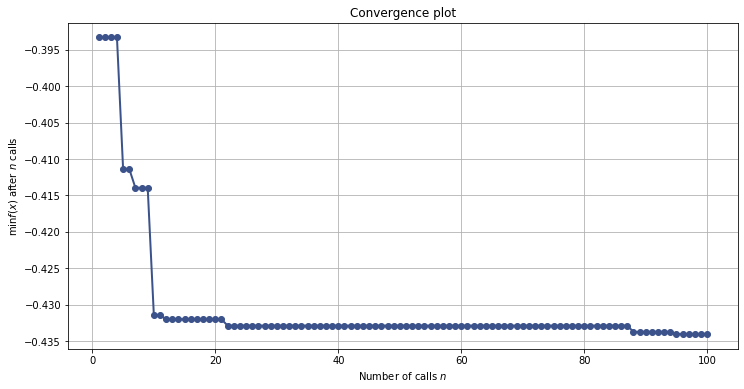

In [98]:
from skopt.plots import plot_convergence
import matplotlib
plot_convergence(res_gp)

In [100]:
scikitopt_model = xgb.XGBClassifier(max_depth=3,
                          learning_rate=0.01000000000000000020816681711721685132943093776702880859375,
                          min_child_weight=5,
                          n_estimators=697,
                          gamma=5,
                          subsample=1,
                          colsample_bytree=0.8294442293809851651786857473780401051044464111328125,
                          scale_pos_weight=0)
scikitopt_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8294442293809852, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=697, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0, seed=None,
              silent=None, subsample=1, verbosity=1)

              precision    recall  f1-score   support

           0       0.50      0.73      0.60       294
           1       0.30      0.16      0.21       270
           2       0.42      0.47      0.44       305
           3       0.46      0.39      0.42       293

    accuracy                           0.44      1162
   macro avg       0.42      0.44      0.42      1162
weighted avg       0.42      0.44      0.42      1162



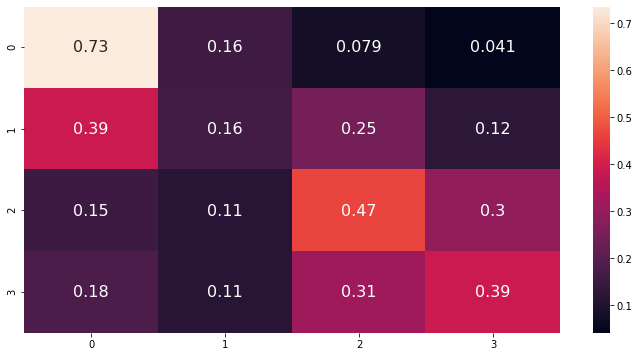

Index(['positionOrder', 'fastest_time_delta', 'fastest_speed_delta',
       'avg_time_delta', 'avg_speed_delta', 'gained_pos',
       'winner_fastest_lap_delta', 'winner_fastest_speed_delta',
       'winner_delta', 'previous_finishes', 'previous_wins',
       'previous_finishes_c', 'previous_wins_c'],
      dtype='object')

XGBoostError: need to call fit or load_model beforehand

In [103]:
y_pred = scikitopt_model.predict(x_test)

# Create confusion matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})

# Print scores
# print('Accuracy: ', accuracy_score(y_test, y_pred))
report_str = classification_report(y_test, y_pred)
print(report_str)
plt.show()

# Show feature columns
display(features.columns)

# Plot feature importances
col_names = list(features.columns)
ordered_features(model_xgb.feature_importances_, col_names)